In [9]:
import pandas as pd
import random
import numpy as np

from pandas import read_excel
from sklearn.model_selection import train_test_split

In [91]:
file_mapping = 'ZHAW_DATA/Mapping_table_hospital_KIS_LIS.xlsx' 
file_roche_LOINC_db = 'Roche_LOINC_Database_filter.xlsm'
file_lab_codes = 'ZHAW_DATA/Example_Data_Laboratory_Codes_eng.xlsx'

df = read_excel(file_roche_LOINC_db, engine='openpyxl')
df.head(2)

,LOINCID,Publication Version ID,Model,Vendor Analyte Code,Vendor Analyte Name,Vendor Specimen Description,Vendor Result Description,LOINC Term,LOINC Long Name,Component,System,LOINC Version ID,Unit
0,30,RMD_v1.0,cobas 6800,89342-0^Babesia^LN,Babesia qual. 480 Tests cobas 6800/8800 IVD,whole blood,Ord,89342-0,Babesia sp 18S rRNA [Presence] in Blood by NAA...,Babesia sp 18S rRNA,Bld,2.68,Ord
1,40,RMD_v1.0,cobas 8800,89342-0^Babesia^LN,Babesia qual. 480 Tests cobas 6800/8800 IVD,whole blood,Ord,89342-0,Babesia sp 18S rRNA [Presence] in Blood by NAA...,Babesia sp 18S rRNA,Bld,2.68,Ord


In [92]:
data_df = df.loc[:,('LOINC Term', 'LOINC Long Name', 'Model')]
print(data_df.head(2))
print(data_df.dtypes)
# First, change the type of the specified columns to 'category'. This will 
# assign a 'code' to each unique category value.
data_df.loc[:,'LOINC Term'] = data_df.loc[:,'LOINC Term'].astype('string')
data_df.loc[:,'Model'] = data_df.loc[:,'Model'].astype('string')
data_df.loc[:,'LOINC Long Name'] = data_df.loc[:,'LOINC Long Name'].astype('category')

# Second, replace the strings with their code values.
data_df.loc[:,'LOINC Code LN'] = data_df.loc[:,'LOINC Long Name'].cat.codes

# Display the table--notice how the above columns are all integers now.
print(data_df.head(2))
print(data_df.dtypes)


  LOINC Term                                    LOINC Long Name       Model
0    89342-0  Babesia sp 18S rRNA [Presence] in Blood by NAA...  cobas 6800
1    89342-0  Babesia sp 18S rRNA [Presence] in Blood by NAA...  cobas 8800
LOINC Term         object
LOINC Long Name    object
Model              object
dtype: object
  LOINC Term                                    LOINC Long Name       Model  \
0    89342-0  Babesia sp 18S rRNA [Presence] in Blood by NAA...  cobas 6800   
1    89342-0  Babesia sp 18S rRNA [Presence] in Blood by NAA...  cobas 8800   

   LOINC Code LN  
0             66  
1             66  
LOINC Term           string
LOINC Long Name    category
Model                string
LOINC Code LN         int16
dtype: object


In [93]:

# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(data_df))
val_size = int(0.1 * len(data_df))
test_size = len(data_df) - (train_size + val_size)

# Sanity check the sizes.
assert((train_size + val_size + test_size) == len(data_df))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(data_df))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using, 
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 5,604
Validation size: 700
      Test size: 701


In [94]:
# This will hold all of the dataset samples, as strings.
sen_w_feats = []

# The labels for the samples.
labels = []

# For each of the samples...
for index, row in data_df.iterrows():

    # Piece it together...    
    combined = ""
    combined += "The Model of the machine used is {:}, ".format(row['Model'])
    #combined += "I am {:} years old. ".format(row["Age"])
    #combined += "I rate this item {:} out of 5 stars. ".format(row["Rating"])

    # Finally, append the review the text!
    combined += row['LOINC Long Name']
    
    # Add the combined text to the list.
    sen_w_feats.append(combined)

    # Also record the sample's label.
    labels.append(row['LOINC Code LN'])

print('  DONE.')

print('Dataset contains {:,} samples.'.format(len(sen_w_feats)))

  DONE.
Dataset contains 7,005 samples.


In [18]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [19]:
!pip install transformers
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached transformers-4.22.2-py3-none-any.whl (4.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.6/197.6 kB 4.0 MB/s eta 0:00:0000:01
  Using cached filelock-3.8.0-py3-none-any.whl (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.9/293.9 kB 8.5 MB/s eta 0:00:00
  Using cached huggingface_hub-0.10.0-py3-none-any.whl (163 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 32.9 MB/s eta 0:00:00a 0:00:01
  Using cached typing_extensions-4.3.0-py3-none-any.whl (25 kB)
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebr

In [97]:
data_df.groupby('LOINC Code LN').describe()

LOINC Term                      LOINC Long Name         \
                   count unique      top freq           count unique   
LOINC Code LN                                                          
0                     17      1  93495-0   17              17      1   
1                     16      1  77752-4   16              16      1   
2                     36      1  83070-3   36              36      1   
3                     36      1  83071-1   36              36      1   
4                      3      1  19321-9    3               3      1   
...                  ...    ...      ...  ...             ...    ...   
506                    6      1   4017-0    6               6      1   
507                    6      1  14899-9    6               6      1   
508                    6      1  97196-0    6               6      1   
509                    6      1  97197-8    6               6      1   
510                    2      1  68324-3    2               2      1   

                                                                      Model  \
                                                             top freq count   
LOINC Code LN                                                                 
0              2-Ethylidene-1,5-Dimethyl-3,3-Diphenylpyrrolid...   17    17   
1              2-Ethylidene-1,5-Dimethyl-3,3-Diphenylpyrrolid...   16    16   
2              25-Hydroxyvitamin D3+25-Hydroxyvitamin D2 [Mas...   36    36   
3              25-Hydroxyvitamin D3+25-Hydroxyvitamin D2 [Mol...   36    36   
4              6-Monoacetylmorphine (6-MAM) [Presence] in Uri...    3     3   
...                                                          ...  ...   ...   
506            quiNIDine [Mass/volume] in Serum or Plasma --t...    6     6   
507                  quiNIDine [Moles/volume] in Serum or Plasma    6     6   
508            quiNIDine [Moles/volume] in Serum or Plasma --...    6     6   
509            quiNIDine [Moles/volume] in Serum or Plasma --...    6     6   
510            von Willebrand factor (vWf).activity actual/no...    2     2   

                                        
              unique          top freq  
LOINC Code LN                           
0                  6  cobas c 501    4  
1                  6  cobas c 501    4  
2                  6  cobas e 411    8  
3                  6  cobas e 411    8  
4                  3  cobas c 501    1  
...              ...          ...  ...  
506                6  cobas c 303    1  
507                6  cobas c 303    1  
508                6  cobas c 303    1  
509                6  cobas c 303    1  
510                2  cobas t 511    1  

[511 rows x 12 columns]

In [98]:
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 511, # The number of output labels--2 for binary classification.
)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [99]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 32

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
learning_rate = 1e-5

# Number of training epochs. 
epochs = 50

In [100]:
max_len = 0

# For every sentence...
for sent in sen_w_feats:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  62


In [101]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Encoding all reviews in the dataset...')

# For every sentence...
for sent in sen_w_feats:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
#print(labels)
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print(input_ids.shape)
print(attention_masks.shape)
print(labels.shape)

print('DONE.')

Encoding all reviews in the dataset...
torch.Size([7005, 62])
torch.Size([7005, 62])
torch.Size([7005])
DONE.


In [102]:
from torch.utils.data import TensorDataset

# Split the samples, and create TensorDatasets for each split. 
train_dataset = TensorDataset(input_ids[train_idx], attention_masks[train_idx], labels[train_idx])
val_dataset = TensorDataset(input_ids[val_idx], attention_masks[val_idx], labels[val_idx])
test_dataset = TensorDataset(input_ids[test_idx], attention_masks[test_idx], labels[test_idx])


In [103]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [104]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [105]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples!)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [106]:
import numpy as np
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [107]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 50 ========
Training...
  Batch    40  of    176.    Elapsed: 0:00:12.
  Batch    80  of    176.    Elapsed: 0:00:25.
  Batch   120  of    176.    Elapsed: 0:00:38.
  Batch   160  of    176.    Elapsed: 0:00:51.

  Average training loss: 6.06
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.13
  Validation Loss: 5.71
  Validation took: 0:00:02

======== Epoch 2 / 50 ========
Training...
  Batch    40  of    176.    Elapsed: 0:00:13.
  Batch    80  of    176.    Elapsed: 0:00:26.
  Batch   120  of    176.    Elapsed: 0:00:39.
  Batch   160  of    176.    Elapsed: 0:00:52.

  Average training loss: 5.56
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.22
  Validation Loss: 5.23
  Validation took: 0:00:02

======== Epoch 3 / 50 ========
Training...
  Batch    40  of    176.    Elapsed: 0:00:13.
  Batch    80  of    176.    Elapsed: 0:00:26.
  Batch   120  of    176.    Elapsed: 0:00:40.
  Batch   160  of    176.    Elapsed: 0:00:53

In [108]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap (doesn't seem to work in Colab).
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,6.06,5.71,0.13,0:00:55,0:00:02
2,5.56,5.23,0.22,0:00:56,0:00:02
3,5.15,4.83,0.29,0:00:58,0:00:03
4,4.77,4.46,0.36,0:00:58,0:00:03
5,4.42,4.14,0.42,0:00:59,0:00:03
6,4.13,3.84,0.44,0:00:59,0:00:03
7,3.85,3.58,0.52,0:00:59,0:00:03
8,3.60,3.33,0.55,0:00:59,0:00:03
9,3.36,3.11,0.60,0:01:00,0:00:03


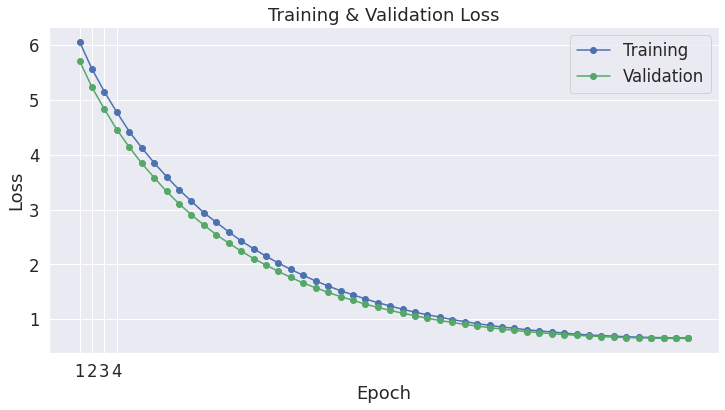

In [109]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
file_lab_codes = 'ZHAW_DATA/Example_Data_Laboratory_Codes_eng.xlsx'

df_new_lab_codes = read_excel(file_lab_codes, engine='openpyxl')
print(df_new_lab_codes.head(2)) # shows headers with top 5 rows

new_data_df = df_new_lab_codes.loc[:,('Parameter', 'Long name', 'Device')]
print(new_data_df.dtypes)
# First, change the type of the specified columns to 'category'. This will 
# assign a 'code' to each unique category value.
new_data_df.loc[:,'Parameter'] = new_data_df.loc[:,'Parameter'].astype('string')
new_data_df.loc[:,'Device'] = new_data_df.loc[:,'Device'].astype('string')
new_data_df.loc[:,'Long name'] = new_data_df.loc[:,'Long name'].astype('category')

# Second, replace the strings with their code values.
new_data_df.loc[:,'Code LN'] = new_data_df.loc[:,'Long name'].cat.codes

# Display the table--notice how the above columns are all integers now.
print(new_data_df.head(2))
print(new_data_df.dtypes)

new_data_size = len(new_data_df)

# Create a list of indeces for all of the samples in the dataset.
new_test_idx = np.arange(0, len(new_data_df))

# Sanity check
assert(len(new_test_idx) == new_data_size)

print('New Test size: {:,}'.format(new_data_size))

# This will hold all of the dataset samples, as strings.
ln_w_dev = []

# The labels for the samples.
new_labels = []

# For each of the samples...
for index, row in new_data_df.iterrows():

    # Piece it together...    
    combined = ""
    combined += "The Model of the machine used is {:}, ".format(row['Device'])
    #combined += "I am {:} years old. ".format(row["Age"])
    #combined += "I rate this item {:} out of 5 stars. ".format(row["Rating"])

    # Finally, append the review the text!
    combined += row['Long name']
    
    # Add the combined text to the list.
    ln_w_dev.append(combined)

    # Also record the sample's label.
    new_labels.append(row['Code LN'])

print('  DONE.')

print('Dataset contains {:,} samples.'.format(len(ln_w_dev)))

max_test_len = 0

# For every sentence...
for ln in ln_w_dev:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    new_input_ids = tokenizer.encode(ln, add_special_tokens=True)

    # Update the maximum sentence length.
    max_test_len = max(max_test_len, len(new_input_ids))

print('New test Max sentence length: ', max_test_len)

# Tokenize all of the sentences and map the tokens to thier word IDs.
new_test_input_ids = []
new_test_attention_masks = []

print('Encoding all reviews in the dataset...')

# For every sentence...
for ln in ln_w_dev:
    encoded_dict = tokenizer.encode_plus(
                        ln,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_test_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    # Add the encoded sentence to the list.    
    new_test_input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    new_test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
#print(labels)
new_test_input_ids = torch.cat(new_test_input_ids, dim=0)
new_test_attention_masks = torch.cat(new_test_attention_masks, dim=0)
new_labels = torch.tensor(new_labels)

print(new_test_input_ids.shape)
print(new_test_attention_masks.shape)
print(new_labels.shape)

print('DONE.')

new_test_dataset = TensorDataset(new_test_input_ids[new_test_idx], new_test_attention_masks[new_test_idx], new_labels[new_test_idx])

In [110]:
# Create a DataLoader to batch our test samples for us. We'll use a sequential
# sampler this time--don't need this to be random!
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 701 test sentences...
    DONE.


In [111]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [112]:
from sklearn.metrics import f1_score

# Calculate the F1
# 'micro' : Calculate metrics globally by counting the total true positives, false negatives and false positives.
f1_micro = f1_score(flat_true_labels, flat_predictions, average='micro')

print('F1 average=micro Score: %.3f' % f1_micro)

# 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
f1_macro = f1_score(flat_true_labels, flat_predictions, average='macro')

print('F1 average=macro Score: %.3f' % f1_macro)

# 'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). 
# This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
f1_weighted = f1_score(flat_true_labels, flat_predictions, average='weighted')

print('F1 average=weighted Score: %.3f' % f1_weighted)

F1 average=micro Score: 0.966
F1 average=macro Score: 0.921
F1 average=weighted Score: 0.955
